# 02 - BFE Heating and Cooling Demand Model
### Author: Daniel Herrera-Russert
#### January 28, 2025

In [ ]:
# !pip install geopandas matplotlib

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyproj import Transformer # for converting coordinates

import geopandas as gpd
from shapely.geometry import Point

# Set the default renderer for JupyterLab
pio.renderers.default = 'iframe'

## 1. Loading the dataset
This dataset, provided by the **Swiss Federal Office of Energy (SFOE)** on the **[opendata.swiss platform](https://opendata.swiss/en/dataset/thermische-netze-nachfrage-wohn-und-dienstleistungsgebaude)**, focuses on **heat and cooling demand** from **residential and commercial buildings**, which is a key factor in the **strategic planning of thermal networks**. It highlights areas suitable for thermal networks, defined as those with a **heat density of at least 700 MWh/a per hectare**, based on data from the **Federal Statistical Office** and the **Federal Office of Energy**. The dataset excludes **industrial heat demand**, emphasizing **low-temperature requirements (12°C to 90°C)** suitable for most buildings. Available in multiple formats (e.g., **GeoTIFF**, **Geopackage**), the data aims to aid public planning by visualizing heat density on a hectare grid but is **not legally binding**.

After a first attempt with a TIFF file, we opt for the GPKG format, as it provides all layers of metadata for each raster unit, and allows for easy data operations.

In [4]:
# Read from URL of the GeoPackage file
gpk_url = "https://data.geo.admin.ch/ch.bfe.fernwaerme-nachfrage_wohn_dienstleistungsgebaeude/fernwaerme-nachfrage_wohn_dienstleistungsgebaeude/fernwaerme-nachfrage_wohn_dienstleistungsgebaeude_2056.gpkg"
save_location = "data/raw/bfe_demand_gdf.geojson"

try:
    bfe_demand_gdf = gpd.read_file(gpk_url)
    
    if bfe_demand_gdf.empty:
        print("The dataset is empty.")
    else:
        print(f"✅ Data successfully collected! Loaded {len(bfe_demand_gdf)} records.")
        # Save to file
        bfe_demand_gdf.to_file(save_location, driver="GeoJSON")
        print(f"✅ Data successfully saved to raw layer.\n    {save_location}")

except Exception as e:
    print("❌ An error occurred while fetching the data.")
    print(f"Error details: {e}")

C:\Users\leina\Documents\HSLU\24.2 Third Semester\W.MSCIDS_DE_DAE01.H2401 - Data Analytics for Energy Systems and IoT\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning:

File /vsimem/pyogrio_488e7b35240048d8afa1e9a1e7eaf58f has GPKG application_id, but non conformant file extension



✅ Data successfully collected! Loaded 227594 records.
✅ Data successfully saved to raw layer.
    data/raw/bfe_demand_gdf.geojson


---

## 2. Exploratory Data Analysis

In [6]:
# Visualize geodataframe
bfe_demand_gdf.head()

,NEEDHOME,NEEDSERVICE,NEEDTOTAL,NOGA,SERVICE,PERCENTGAS,PERCENTOIL,PERCENTPUMP,PERCENTREMOTEHEAT,STYLE,OBJECTID,geometry
0,44.4,10.5,54.9,47: Detailhandel (ohne Handel mit Motorfahrzeu...,100 % Branche 13: Handel,0.0,75.0,0.0,0.0,1,1,"POLYGON ((2486199.234 1111500.128, 2486199.235..."
1,36.0,23.0,59.0,71: Architektur- und Ingenieurbüros; technisch...,100 % Branche 19: Andere Dienstleistungen,0.0,0.0,0.0,0.0,1,2,"POLYGON ((2486399.229 1111600.125, 2486399.23 ..."
2,335.4,43.0,378.4,47: Detailhandel (ohne Handel mit Motorfahrzeu...,76 % Branche 18: Gesundheits- / Sozialwesen,0.0,47.4,0.0,52.6,2,3,"POLYGON ((2486399.23 1111700.124, 2486399.232 ..."
3,77.6,0.0,77.6,,,0.0,100.0,0.0,0.0,1,4,"POLYGON ((2486399.234 1111900.121, 2486399.235..."
4,55.0,0.0,55.0,,,0.0,33.3,33.3,0.0,1,5,"POLYGON ((2486499.225 1111600.125, 2486499.227..."


The dataset provides geospatial information on **heat demand** for residential and commercial buildings across **Switzerland**. It includes estimated energy consumption and demand distribution, serving as a key resource for **energy planning and infrastructure development**.

The dataset originates from the **Swiss Federal Office of Energy (BFE)** and is available as a **GeoPackage (`GPKG`)** file. The data has been processed to provide **both residential and commercial heat demand values**, along with information about the energy source distribution.

The documentation can be found [here](https://www.bfe.admin.ch/bfe/de/home/versorgung/digitalisierung-und-geoinformation/geoinformation/geodaten/thermische-netze/waerme-und-kaeltenachfrage-wohn-und-dienstleistungsgebaeude.html).

### **Attributes of the Heat Demand Model**
- **`NEEDHOME`**: Estimated residential heat demand (`MWh/a`).  
- **`NEEDSERVICE`**: Estimated commercial/service-sector heat demand (`MWh/a`).  
- **`NEEDTOTAL`**: Combined residential and commercial heat demand (`MWh/a`).  
- **`NOGA`**: Industry classification code based on economic activity (e.g., retail, healthcare, architecture).  
- **`SERVICE`**: Description of the dominant commercial sector for each region.  
- **`PERCENTGAS`**: Percentage of buildings using gas heating.  
- **`PERCENTOIL`**: Percentage of buildings using oil heating.  
- **`PERCENTPUMP`**: Percentage of buildings using heat pumps.  
- **`PERCENTREMOTEHEAT`**: Percentage of buildings connected to a district heating system.  
- **`STYLE`**: Categorical classification of heat demand, divided into six levels based on the total heat demand (`MWh/a`). Each level corresponds to a specific range of demand and is visualized using a color gradient to indicate increasing heat intensity. The classification is applied separately for residential/commercial and industrial buildings. See table below for more information.  
- **`OBJECTID`**: Unique identifier for each polygonal region.  
- **`geometry`**: Geospatial representation of demand regions as **polygons**.

The `STYLE` attribute categorizes heat demand into six levels:

| `STYLE` | Heat Demand (MWh/a) | Color (RGB) | Interpretation |
|---------|------------------|--------------|----------------|
| **1** | **0–300** MWh/a | `RGB(254,217,118)` | Very low heat demand |
| **2** | **301–500** MWh/a | `RGB(254,178,76)` | Low heat demand |
| **3** | **501–1,000** MWh/a | `RGB(253,141,60)` | Moderate heat demand |
| **4** | **1,001–3,000** MWh/a | `RGB(252,78,42)` | High heat demand |
| **5** | **3,001–10,000** MWh/a | `RGB(227,26,28)` | Very high heat demand |
| **6** | **>10,000** MWh/a | `RGB(177,0,38)` | Extremely high heat demand |

This classification is used to **visualize heat demand hotspots**, where **higher values (dark red)** indicate areas with the highest heat demand, making them **suitable for district heating networks**.

### **Dataset Formats & Accessibility**
The dataset is available in multiple formats:  
- **GeoPackage (`GPKG`)**  
- **GeoTIFF (`GeoTIFF`)**  
- **Shapefile (`SHP`)**  
- **Web Map Services (`WMS`, `WMTS`)**  
- **REST API**  

It can be accessed via the **GIS-ZH platform**, **REST API**, or **OpenDataSwiss**.

### **Key Improvements & Changes**
- **Transformed coordinate system**: Originally stored in **`EPSG:2056 (LV95)`**, but can be converted to **`EPSG:4326 (WGS84)`** for standardized spatial analysis.  
- **Added energy source percentages**: Data includes breakdowns of **gas, oil, heat pumps, and district heating** usage.  
- **Integrated commercial sector classification**: Includes **`NOGA`** codes for economic activity.  
- **Updated geometry representation**: Demand is stored as **polygon features**, allowing for spatial queries and overlays.  

This dataset is **a valuable tool for spatial analysis and urban energy planning**, supporting **renewable energy integration and district heating expansion** for the entire country.

---

## 3. Spatial Join of Borehole Data with Heat Demand Information

Leveraging the properties of GeoJSON files and GeoPandas objects, we can proceed with a join between the two datasets covered until now. Since the BFE Heat Demand model is expressed by means of raster data, consisting of pixel cells of limited resolution covering the entire country, a query can be conducted to select the boreholes from the ZH dataset contained within, and thus combine the information into one single data object.

The process starts with loading both datasets:

In [10]:
# Step 1: Load the borehole dataset and save as GeoPandas
geojson_path = "data/transformed/zh_geothermal_probes.geojson"
zh_geothermal_probes_gdf = gpd.read_file(geojson_path)

# The other dataset from the BFE is already loaded, and is also a gpd object

In [5]:
# Check current CRS
print(f"CRS of Boreholes: {zh_geothermal_probes_gdf.crs}")
print(f"CRS of BFE Demand Model: {bfe_demand_gdf.crs}")

CRS of Boreholes: EPSG:4326
CRS of BFE Demand Model: EPSG:2056


In [6]:
# Force override the incorrect CRS (assuming it's wrongly set)
bfe_demand_gdf = bfe_demand_gdf.set_crs(epsg=4326, allow_override=True)

# Verify the transformation
print(f"Updated CRS of BFE Demand Model: {bfe_demand_gdf.crs}")

Updated CRS of BFE Demand Model: EPSG:4326


In [7]:
# Step 3: Perform a spatial join
# Join based on geometry, matching borehole points to polygons in the heat demand data
joined = gpd.sjoin(
    zh_geothermal_probes_gdf, 
    bfe_demand_gdf, 
    how="left",  # Keeps all boreholes, even if no match is found
    predicate="within"  # Ensures the points fall within polygons
)

joined.head()

,gml_id,x,y,Waermeentnahme,Waermeeintrag,Sondentiefe,Gesamtsondenzahl,GBS-Nummer,Bohrprofil,lon,...,NEEDSERVICE,NEEDTOTAL,NOGA,SERVICE,PERCENTGAS,PERCENTOIL,PERCENTPUMP,PERCENTREMOTEHEAT,STYLE,OBJECTID
0,erdwaermesonden.1464734,2684789,1248345,20.4,0.0,250,3.0,b 00-10370,0,8.561441,...,78.5,798.1,70: Verwaltung und Führung von Unternehmen und...,59 % Branche 19: Andere Dienstleistungen,14.3,57.1,28.6,0.0,3.0,153369.0
1,erdwaermesonden.1464735,2684962,1248289,68.0,0.0,250,10.0,b 00-10371,1,8.563721,...,10.5,393.9,64: Erbringung von Finanzdienstleistungen,100 % Branche 15: Kredit / Versicherungen,0.0,14.3,85.7,0.0,2.0,153613.0
2,erdwaermesonden.1464736,2684633,1248535,12.5,6.0,250,2.0,b 00-10287,0,8.559411,...,55.5,620.6,"74: Sonstige freiberufliche, wissenschaftliche...",58 % Branche 18: Gesundheits- / Sozialwesen,20.0,40.0,40.0,0.0,3.0,153245.0
3,erdwaermesonden.1464737,2684626,1248526,12.5,6.0,250,2.0,b 00-10288,0,8.559317,...,55.5,620.6,"74: Sonstige freiberufliche, wissenschaftliche...",58 % Branche 18: Gesundheits- / Sozialwesen,20.0,40.0,40.0,0.0,3.0,153245.0
4,erdwaermesonden.1464738,2684623,1248519,12.5,6.0,250,2.0,b 00-10289,0,8.559276,...,55.5,620.6,"74: Sonstige freiberufliche, wissenschaftliche...",58 % Branche 18: Gesundheits- / Sozialwesen,20.0,40.0,40.0,0.0,3.0,153245.0


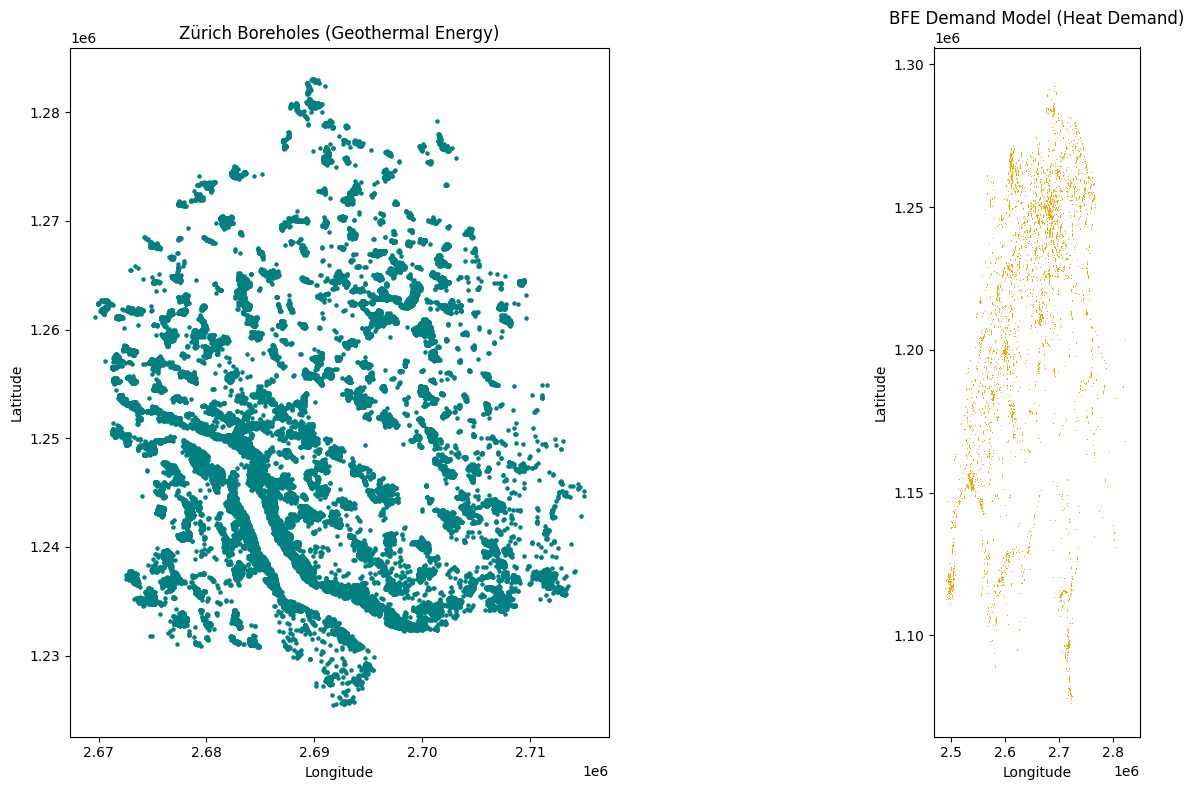

In [8]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Plot Zürich Boreholes
zh_geothermal_probes_gdf.plot(
    ax=ax[0],
    color='teal',
    markersize=5,
    legend=True,
)
ax[0].set_title("Zürich Boreholes (Geothermal Energy)")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

# Plot BFE Demand Model
bfe_demand_gdf.plot(
    ax=ax[1],
    color='orange',
    markersize=5,
    legend=True,
)
ax[1].set_title("BFE Demand Model (Heat Demand)")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

# Adjust layout for better visualization
plt.tight_layout()

# Show the map plots
plt.show()

The plot confirms that the data is treated correctly, and is also set to the correct coordinate system.

We can create new relational table, containing exclussively the data from the BFE Model, linking the relevant values to the ID of the boreholes from the ZH Wärmekataster dataset, and merge both tables in a later step:

In [9]:
# Select only the new relevant columns from the BFE dataset
selected_columns = [
    "gml_id",
    "OBJECTID",
    "NEEDHOME",
    "NEEDSERVICE",
    "PERCENTGAS",
    "PERCENTOIL",
    "PERCENTPUMP", 
    "PERCENTREMOTEHEAT",
    "STYLE"    
]

final_df = joined[selected_columns]

# Step 5: Save the resulting dataset
save_path = "data/transformed/boreholes_with_demand.csv"
final_df.to_csv(save_path, index=False)
print(f"File saved to {save_path}")

# Display the first few rows
final_df.head()

File saved to data/transformed/boreholes_with_demand.csv


,gml_id,OBJECTID,NEEDHOME,NEEDSERVICE,PERCENTGAS,PERCENTOIL,PERCENTPUMP,PERCENTREMOTEHEAT,STYLE
0,erdwaermesonden.1464734,153369.0,719.6,78.5,14.3,57.1,28.6,0.0,3.0
1,erdwaermesonden.1464735,153613.0,383.4,10.5,0.0,14.3,85.7,0.0,2.0
2,erdwaermesonden.1464736,153245.0,565.1,55.5,20.0,40.0,40.0,0.0,3.0
3,erdwaermesonden.1464737,153245.0,565.1,55.5,20.0,40.0,40.0,0.0,3.0
4,erdwaermesonden.1464738,153245.0,565.1,55.5,20.0,40.0,40.0,0.0,3.0


Rows with `NaN` values in the heat demand fields (e.g., `NEEDHOME`, `NEEDSERVICE`, `PERCENTGAS`) occur when borehole points fall within raster cells that lack corresponding attribute data in the GeoPackage. This typically happens in areas where no heat demand or related metrics were recorded, such as uninhabited regions, water bodies, or areas excluded from the dataset's scope. These `NaN` values indicate the absence of information for those specific locations and can be handled based on the analysis requirements, either by filtering them out or imputing default values.
